<a href="https://colab.research.google.com/github/mirkousuelli/time-series-analysis/blob/main/identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import levinson_durbin

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Covariance and Partial Covariance

In [2]:
''' AR(n) / MA(n) / ARMA(n,m) generator method '''
def arma_process(ar_coeff, ma_coeff, mean, std, samples):
  # generating the white noise (mean,ntd)
  e = np.random.normal(mean, std, samples)
  # starting from a pure noisy signal
  y = np.copy(e)
  # process
  for t in range(max(len(ar_coeff), len(ma_coeff)), samples):
    # AR() model
    order = 1
    for ar in ar_coeff:
      y[t] += ar * y[t - order]
      order += 1
    # MA() model
    order = 1
    for ma in ma_coeff:
      y[t] += ma * e[t - order]
      order += 1
  # returning the model
  return y

''' ARX(n,m) / MAX(n,m) / ARMAX(n,m,u) generator method '''
def armax_process(ar_coeff, ma_coeff, x_coeff, mean, std, x_mean, x_std, samples):
  # generating the white noise (mean,ntd)
  e = np.random.normal(mean, std, samples)
  u = np.random.normal(x_mean, x_std, samples)
  # starting from a pure noisy signal
  y = np.copy(e)
  # process
  for t in range(max(len(ar_coeff), len(ma_coeff), len(x_coeff)), samples):
    # AR() model
    order = 1
    for ar in ar_coeff:
      y[t] += ar * y[t - order]
      order += 1
    # MA() model
    order = 1
    for ma in ma_coeff:
      y[t] += ma * e[t - order]
      order += 1
    # X() model
    order = 1
    for x in x_coeff:
      y[t] += x * u[t - order]
      order += 1
  # returning the model
  return y

Given a measured process realization in order to understand the family model that is able to describe better the data it is possible to analyse:


1.   <u>Normalized covariance function</u> : 
> $\rho(\tau)=\frac{\sum_{t=1}^{N} y(t)y(t-\tau)}{\sum_{t=1}{N} y(t)y(t)}$

if $\rho(\tau) = 0$ for $\tau > n \rightarrow y(t) \in MA(n)$

\\

2.   <u>Partial covariance function</u> : \\
$PARCOV(\tau) = $ last identified parameter $a_\tau$ of an $AR(\tau) model$
> $y(t) = a_1y(t-1)+...+a_\tau y(t-\tau)+\xi(t)$

if $PARCOV(\tau) = 0$ for $\tau > n \rightarrow y(t) \in AR(n)$

\\

NB. if neither check had worked, then it is possible to use an ARMA model whose orders can be decided by analyzing objective criteria as FPS, AIC or MDL.


---



### AR(n) data identification : $PARCOV(\tau)$

Let's apply identification to this AR(2) process:

> $y(t)=1.2y(t-1)-0.32y(t-2)+\xi(t)$ \\
 with  $\xi(t) \sim WN(0,1)$

In [ ]:
# parameters
ar = [1.2, -0.32]
ma = []
mean = 0
std = 1
samples = 5000

# model
y = arma_process(ar, ma, mean, std, samples)

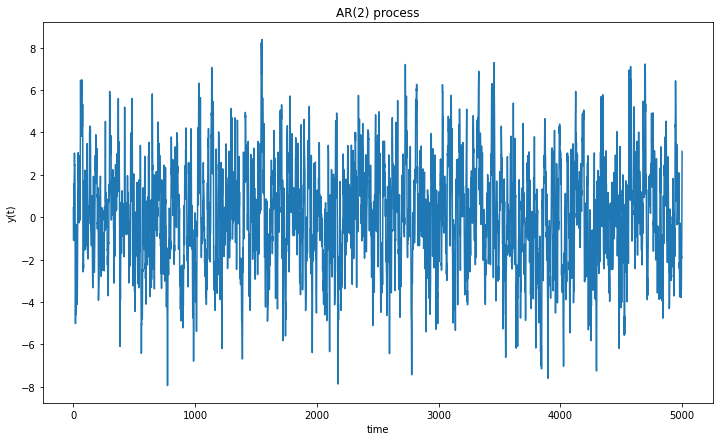

In [ ]:
# plotting
plt.figure(figsize=[12,7])
plt.plot(y)
plt.ylabel("y(t)")
plt.xlabel("time")
plt.title("AR(2) process")
plt.show()

$PARCOV(\tau)$ can be considered null for $\tau \ge 2$ :

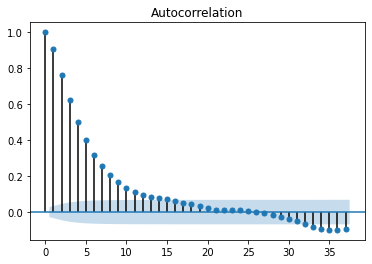

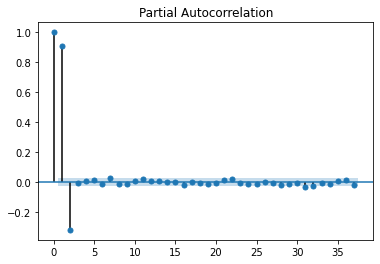

In [ ]:
# normalized covariance function
plot_acf(y);

# partial covariance function
plot_pacf(y);

### MA(n) data identification : $\rho(\tau)$

Let's apply identification to this MA(2) process:

> $y(t)=\xi(t)+\xi(t-1)+0.5\xi(t-2)$ \\
 with  $\xi(t) \sim WN(0,1)$

In [ ]:
# parameters
ar = []
ma = [1, 0.5]
mean = 0
std = 1
samples = 2000

# model
y = arma_process(ar, ma, mean, std, samples)

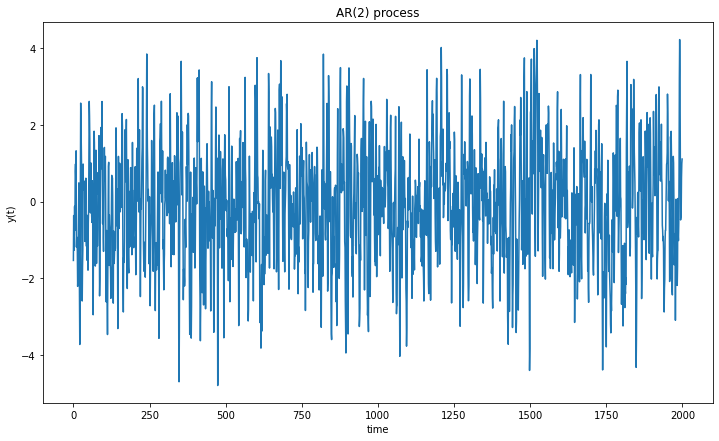

In [ ]:
# plotting
plt.figure(figsize=[12,7])
plt.plot(y)
plt.ylabel("y(t)")
plt.xlabel("time")
plt.title("MA(2) process")
plt.show()

$\rho(\tau)$ can be considered null for $\tau \ge 2$ :

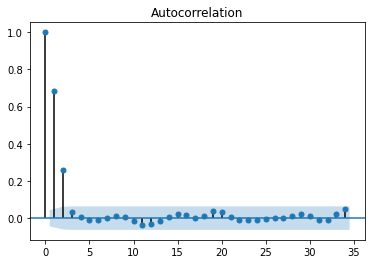

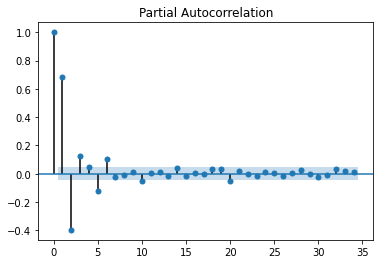

In [ ]:
# normalized covariance function
plot_acf(y);

# partial covariance function
plot_pacf(y);

### ARMA(n,m) data identification

Let's apply identification to this ARMA(2,2) process:

> $y(t)=1.2y(t-1)-0.32y(t-2)+\xi(t-1)+0.5\xi(t-2)+\xi(t)$ \\
 with  $\xi(t) \sim WN(0,1)$

In [ ]:
# parameters
ar = [1.2, -0.32]
ma = [1, 0.5]
mean = 0
std = 1
samples = 2000

# model
y = arma_process(ar, ma, mean, std, samples)

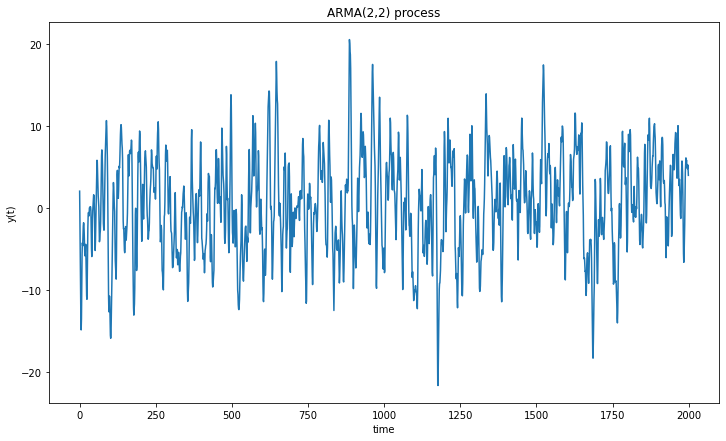

In [ ]:
# plotting
plt.figure(figsize=[12,7])
plt.plot(y)
plt.ylabel("y(t)")
plt.xlabel("time")
plt.title("ARMA(2,2) process")
plt.show()

None can be considered null:

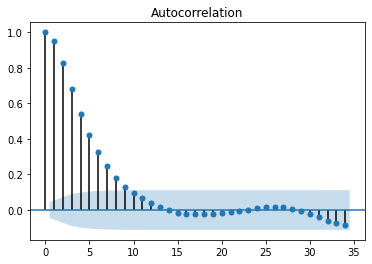

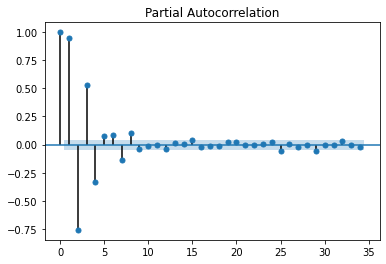

In [ ]:
# normalized covariance funtion
plot_acf(y);

# partial covariance function
plot_pacf(y);

## Criterions

Considering the prediction error variance as:


> $J_N(\hat{\theta}_N)=E[\varepsilon(t, \hat{\theta}_N)^2] = E[(y(t) - \hat{y}(t, \hat{\theta}_N))^2]=E[(y(t)-\varphi(t)'\hat{\theta}_N]$

where: \\
*   Observations : $\varphi(t) = [y(t-1) ... y(t-n)]'$
*   Parameters estimated : $\theta = [a_1 ... a_n]'$




In [16]:
def sampled_var_pred_error(y, order, samples):
  err = 0
  for t in range(order, samples):
    phi = np.array([y[t - i] for i in range(1, order + 1)])
    err += (y[t] - (ar_coeff_order[order - 1].T).dot(phi)) ** 2
  err /= samples
  return err


### 1.   <b>FPE</b> : <u>Final Predictor Error</u>
> $FPE(n) = \frac{N+n}{N-n}J_N(\hat{\theta}_N)$

$n$ = number of parameters to identify \\
$N$ = number of samples of the realization \\
$J_N(\hat{\theta}_N)$ = is the sampled variance of the prediction error

In [17]:
def fpe(n_params, n_samples, pred_err_var):
  return (n_samples + n_params) / (n_samples - n_params) * pred_err_var

### 2.   <b>AIC</b> : <u>Akaike Information Criterion</u>
> $AIC(n) = 2\frac{n}{N}+ln[J_N(\hat{\theta}_N)]$

If the number of samples N is large, then FPE and AIC tend to indicate the same order.

In [18]:
def aic(n_params, n_samples, pred_err_var):
  return 2 * n_params / n_samples + np.log(pred_err_var)

### 3.   <b>MDL</b> : <u>Minimum Description Length</u>
> $MDL(n) = ln(N)\frac{n}{m}+ln[J_N(\hat{\theta}_N)]$

If N is not so large, the complexity order is penalized with AIC and MDL

In [19]:
def mdl(n_params, n_samples, pred_err_var):
  return np.log(n_samples) * n_params / n_samples + np.log(pred_err_var)



---



## Procedure
###AR/ARX model
Let's consider a single realization with N samples of the following AR(2) model:


> $y(t) = 1.2y(t-1)-0.32y(t-2)+\xi(t)$

with $\xi(t) \sim WN(0,1)$ \\

We consider $N = 2000$




### 1) Realization measurments
We start from a mesured process realization $y(1), y(2), ..., y(N).$


In [9]:
# parameters
ar = [1.2, -0.32]
ma = []
mean = 0
std = 1
samples = 2000

# model
y = arma_process(ar, ma, mean, std, samples)

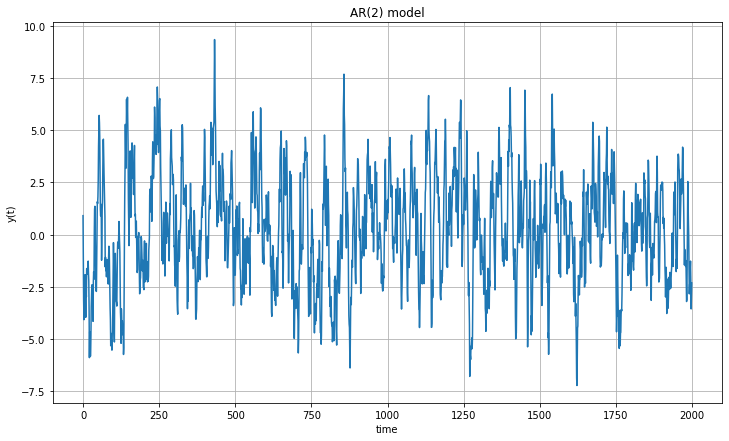

In [10]:
plt.figure(figsize = [12, 7])
plt.title("AR(2) model")
plt.grid()
plt.plot(y)
plt.xlabel("time")
plt.ylabel("y(t)")
plt.show()

### 2) Parameters prediction
We derive the identified AR model by means of Least Square or Durbin-Levinson method for many orders from 1 to $n$. <i>(e.g. $n = 10$)</i>


In [11]:
complexity = [x for x in range(1, 11)] # 10 + 1 for range()

#### 2.1) LS method

In [ ]:
# TODO

#### 2.2) Durbin-Levinson method
This method returns:

*   <u>sigma_v</u> (float) – estimate of the error variance
*   <u>arcoefs</u> (ndarray) – estimate of the autoregressive coefficients
*   <u>pacf</u> (ndarray) – partial autocorrelation function
*   <u>sigma</u> (ndarray) – entire sigma array from intermediate result, last value is sigma_v
*   <u>phi</u> (ndarray) – entire phi array from intermediate result, last column contains autoregressive coefficients for AR(nlags) with a leading 1


<i>We are only interested in the first three outcomes.</i>

In [12]:
ar_coeff_order = []

# we assume the same complexity order for the exogenous part and the noisy one
for order in complexity:
  # levinson-durbin method
  sigma_v, arcoefs, pacf, sigma, phi = levinson_durbin(y, order)

  # storing outcomes for each order of complexity
  ar_coeff_order.append(arcoefs)

### 3) Variance prediction error
For each model, we compute the sampled variace of the prediction error $J_N(\hat{\theta}_N)$.

In [13]:
var_pred_error_order = []
for order in complexity:
  # computing the sampled variance of the prediction error
  j = sampled_var_pred_error(y, order, samples)
  # appending it to the order list
  var_pred_error_order.append(j)

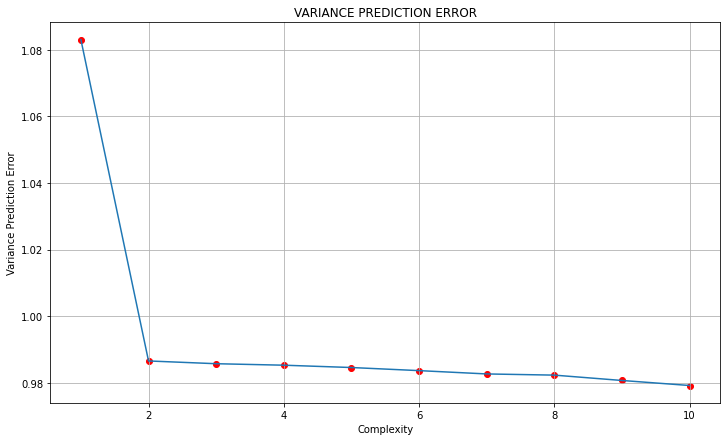

In [14]:
plt.figure(figsize=[12,7])
plt.grid()
plt.plot(complexity, var_pred_error_order)
plt.scatter(complexity, var_pred_error_order, marker="o", color="red")
plt.xlabel("Complexity")
plt.ylabel("Variance Prediction Error")
plt.title("VARIANCE PREDICTION ERROR")
plt.show()

### 4) Criterion computation
We compute the FPE, AIC and MDL.

####4.1) FPE

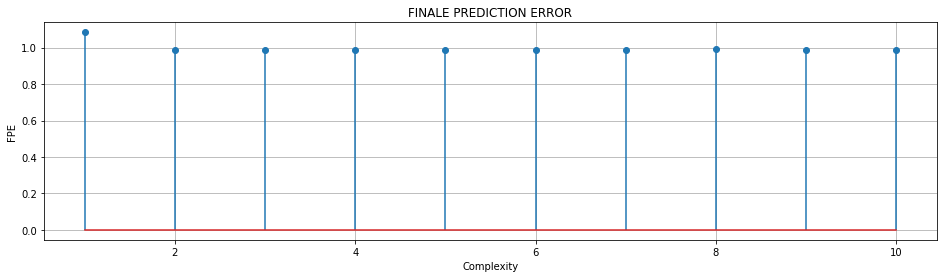


FPE best complexity order : 2


In [20]:
# list used to store fpe value
fpe_order = []
# starting from zero, then it increments
order = 0

# computing FPE for each complexity order
for err in var_pred_error_order:
  order += 1
  fpe_order.append(fpe(order, samples, err))

# plotting
plt.figure(figsize=[16,4])
plt.grid()
plt.stem(complexity, fpe_order, use_line_collection=True)
plt.xlabel("Complexity")
plt.ylabel("FPE")
plt.title("FINALE PREDICTION ERROR")
plt.show()

# evaluation
print("\nFPE best complexity order : " + str(fpe_order.index(min(fpe_order)) + 1))

#### 4.2) AIC

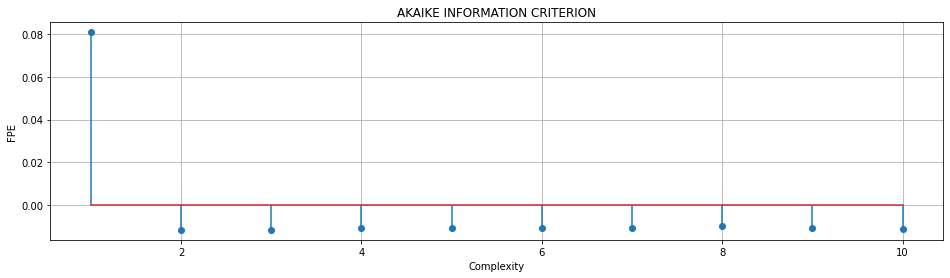


AIC best complexity order : 2


In [21]:
# list used to store aic values
aic_order = []
# starting from zero, then it increments
order = 0

# computing FPE for each complexity order
for err in var_pred_error_order:
  order += 1
  aic_order.append(aic(order, samples, err))

# plotting
plt.figure(figsize=[16,4])
plt.grid()
plt.stem(complexity, aic_order, use_line_collection=True)
plt.xlabel("Complexity")
plt.ylabel("FPE")
plt.title("AKAIKE INFORMATION CRITERION")
plt.show()

# evaluation
print("\nAIC best complexity order : " + str(aic_order.index(min(aic_order)) + 1))

#### 4.3) MDL

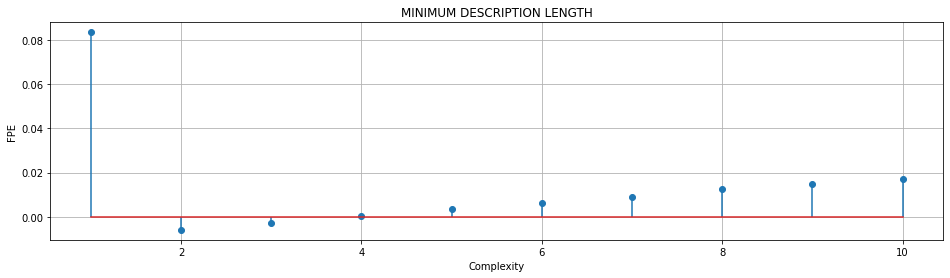


MDL best complexity order : 2


In [22]:
# list used to store mdl values
mdl_order = []
# starting from zero, then it increments
order = 0

# computing FPE for each complexity order
for err in var_pred_error_order:
  order += 1
  mdl_order.append(mdl(order, samples, err))

# plotting
plt.figure(figsize=[16,4])
plt.grid()
plt.stem(complexity, mdl_order, use_line_collection=True)
plt.xlabel("Complexity")
plt.ylabel("FPE")
plt.title("MINIMUM DESCRIPTION LENGTH")
plt.show()

# evaluation
print("\nMDL best complexity order : " + str(mdl_order.index(min(mdl_order)) + 1))

### 5) Model Selection
We choose the order of the model in relation with the criterions (the best order is the one with minimum criterion value)

In [23]:
realizations = [x for x in range(1, 31)] # 30 + 1 for range()

In [24]:
''' ------------------------- INITIALIZATION ------------------------- '''
# parameters
ar = [1.2, -0.32]
ma = []
x = [1, 0.5]
mean = 0
std = 1
x_mean = 0
x_std = 2

def criteria_arx_identification(y, order_ub):
  ''' ------------------------- IDENTIFICATION ------------------------- '''
  var_pred_error_order = []

  # we assume the same complexity order for the exogenous part and the noisy one
  for order in order_ub:
    # levinson-durbin method
    sigma_v, arcoefs, pacf, sigma, phi = levinson_durbin(y, order)

    # computing the sampled variance of the prediction error
    j = sampled_var_pred_error(y, order, samples)

    # storing outcomes for each order of complexity
    var_pred_error_order.append(j)

  ''' ---------------------- CRITERIA COMPUTATION --------------------- '''
  # list used to store criteria values
  fpe_order = []
  aic_order = []
  mdl_order = []

  # starting from zero, then it increments
  order = 0

  # computing FPE for each complexity order
  for err in var_pred_error_order:
    order += 1
    #criteria
    fpe_order.append(fpe(order, samples, err))
    aic_order.append(aic(order, samples, err))
    mdl_order.append(mdl(order, samples, err))

  ''' -------------------------- EVALUATION -------------------------- '''
  best_fpe = fpe_order.index(min(fpe_order)) + 1
  best_aic = aic_order.index(min(aic_order)) + 1
  best_mdl = mdl_order.index(min(mdl_order)) + 1

  return best_fpe, best_aic, best_mdl

#### 5.1) 30 Samples

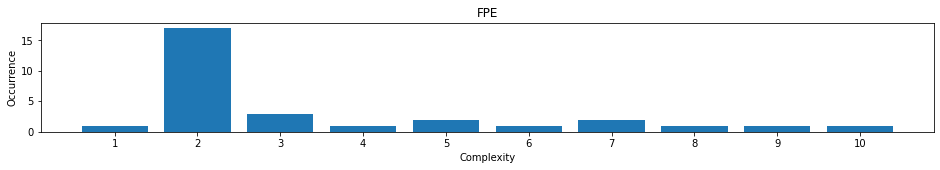

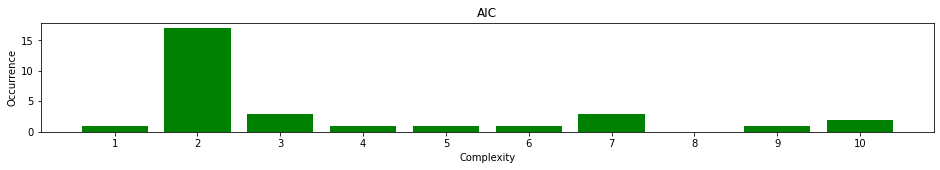

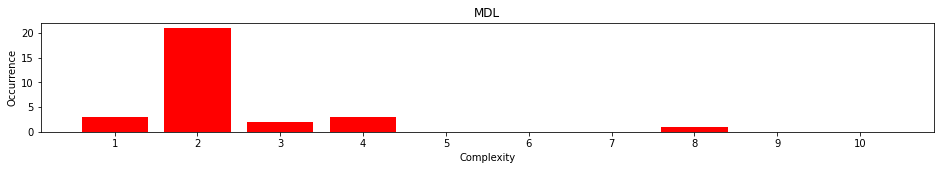

In [25]:
samples = 30

# indexed occurrence
occurrence = {
    "fpe" : [0 for i in complexity],
    "aic" : [0 for i in complexity],
    "mdl" : [0 for i in complexity]
}

# iterating multiple realizations
for i in realizations:
  # model processing
  y = armax_process(ar, ma, x, mean, std, x_mean, x_std, samples)
  # identification
  best_fpe, best_aic, best_mdl = criteria_arx_identification(y, complexity)
  # updating model selection
  occurrence["fpe"][best_fpe - 1] += 1
  occurrence["aic"][best_aic - 1] += 1
  occurrence["mdl"][best_mdl - 1] += 1

'''---------------------------- PLOTTING ---------------------------- '''
# FPE
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["fpe"])
plt.title("FPE")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

# AIC
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["aic"], color="green")
plt.title("AIC")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

# MDL
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["mdl"], color="red")
plt.title("MDL")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

#### 5.2) 50 Samples

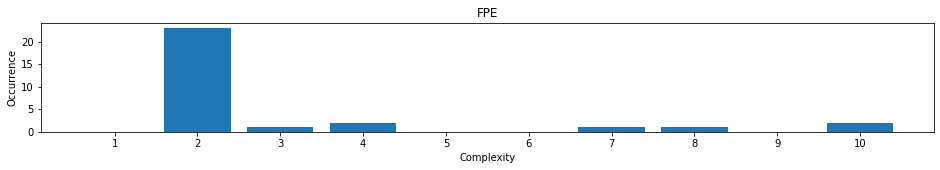

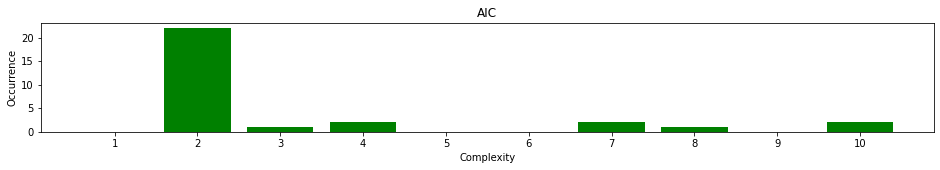

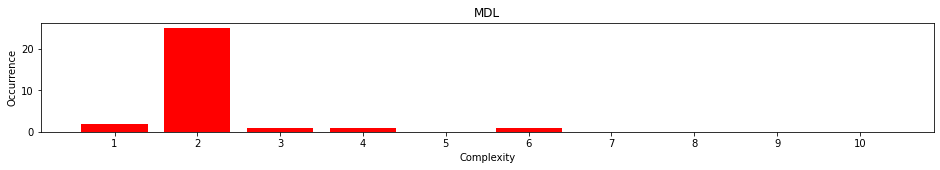

In [26]:
samples = 50

# indexed occurrence
occurrence = {
    "fpe" : [0 for i in complexity],
    "aic" : [0 for i in complexity],
    "mdl" : [0 for i in complexity]
}

# iterating multiple realizations
for i in realizations:
  # model processing
  y = armax_process(ar, ma, x, mean, std, x_mean, x_std, samples)
  # identification
  best_fpe, best_aic, best_mdl = criteria_arx_identification(y, complexity)
  # updating model selection
  occurrence["fpe"][best_fpe - 1] += 1
  occurrence["aic"][best_aic - 1] += 1
  occurrence["mdl"][best_mdl - 1] += 1

'''---------------------------- PLOTTING ---------------------------- '''
# FPE
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["fpe"])
plt.title("FPE")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

# AIC
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["aic"], color="green")
plt.title("AIC")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

# MDL
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["mdl"], color="red")
plt.title("MDL")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

#### 5.3) 500 Samples, 30 Realizations

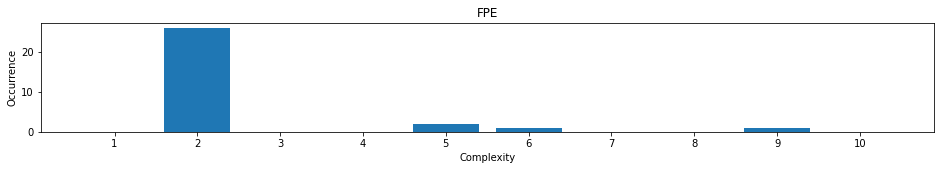

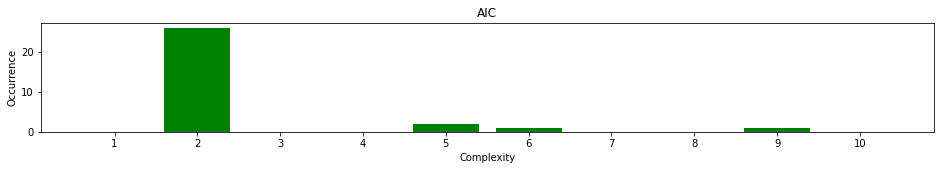

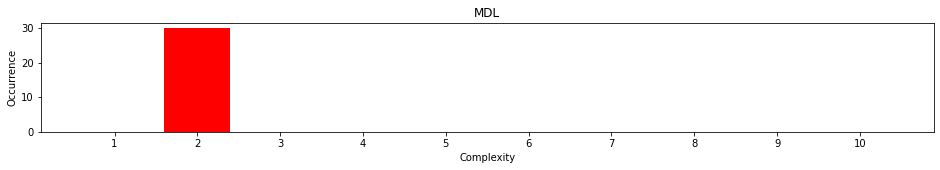

In [27]:
samples = 500

# indexed occurrence
occurrence = {
    "fpe" : [0 for i in complexity],
    "aic" : [0 for i in complexity],
    "mdl" : [0 for i in complexity]
}

# iterating multiple realizations
for i in realizations:
  # model processing
  y = armax_process(ar, ma, x, mean, std, x_mean, x_std, samples)
  # identification
  best_fpe, best_aic, best_mdl = criteria_arx_identification(y, complexity)
  # updating model selection
  occurrence["fpe"][best_fpe - 1] += 1
  occurrence["aic"][best_aic - 1] += 1
  occurrence["mdl"][best_mdl - 1] += 1

'''---------------------------- PLOTTING ---------------------------- '''
# FPE
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["fpe"])
plt.title("FPE")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

# AIC
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["aic"], color="green")
plt.title("AIC")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()

# MDL
plt.figure(figsize=[16,2])
plt.bar(complexity, occurrence["mdl"], color="red")
plt.title("MDL")
plt.xlabel("Complexity")
plt.ylabel("Occurrence")
plt.xticks(complexity)
plt.show()